In [19]:
import pandas as pd
import os
import numpy as np
from IPython.core.display_functions import clear_output
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from datetime import datetime
import time
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

In [20]:
DATA_PATH = '../../Pokemon-data/'
NORMALIZED_DATA = '../../Training-baseline/'
SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
MODEL_NAME = "freeze-customLR"
checkpoint_path = './saved-models/'
TRAINING_METRICS = './training-metrics/'
n_epochs_stop = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
class CustomDataset(Dataset):
	def __init__(self, x, y, img_dir):
		self.x = x
		self.y = y
		self.img_dir = img_dir
		self.classes = np.unique(self.y)


	def __len__(self):
		return len(self.x)


	def __getitem__(self, idx):
		img_path = os.path.join(self.img_dir, self.x[idx])
        # use the slice to remove a possible 4th alpha channel
		image = np.load(img_path)[:,:,:3]
		image = image.astype(np.float32)
		label = self.y[idx]
		return image, label

In [22]:
def stratified_split(dataset, labels):
    x_train, x_val, y_train, y_val = train_test_split(dataset['file_name'].to_numpy(),
                                                  labels,
                                                  test_size=0.25,
                                                  stratify=dataset['label'],
                                                  random_state=SEED)

    trainSet = CustomDataset(x_train, y_train, NORMALIZED_DATA)
    valSet = CustomDataset(x_val, y_val, NORMALIZED_DATA)
    return trainSet, valSet

In [23]:
def print_performance_metrics(currentEpoch, avgTrainLoss, trainCorrect, avgValLoss, valCorrect, trainf1, valf1):
    print(f"---------------------------------------------------- ")
    print(f"[INFO] EPOCH: {currentEpoch + 1}/{EPOCHS}")
    print(f"Train loss: {avgTrainLoss :.6f}, Train accuracy: {trainCorrect :.4f}")
    print(f"Val loss: 	{avgValLoss :.6f}, Val accuracy:   {valCorrect :.4f}")
    print(f"Train F1: 	{trainf1 :.6f}")
    print(f"Val F1: 	{valf1 :.6f}")
    print(f"---------------------------------------------------- \n")

In [24]:
# read data
csv_data = pd.read_csv("./metadata/training-list.csv", index_col=0)

y_train = np.zeros((len(csv_data["y_train_columns"]),csv_data["y_train_columns"][0]))
for i in range(csv_data["y_train_columns"][0]):
    y_train[:,i] = csv_data["y_train"+str(i)]

encoded_data = csv_data.drop(csv_data.columns[(csv_data.shape[1]-csv_data["y_train_columns"][0]-1):csv_data.shape[1]], axis=1)

In [25]:
train, val = stratified_split(encoded_data, y_train)
trainDataLoader = DataLoader(train, batch_size=BATCH_SIZE)
valDataLoader = DataLoader(val, batch_size=BATCH_SIZE)

trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [26]:
def get_baseline_model():
    model = models.efficientnet_b0(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [27]:
def get_pretrained_frozen_model():
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [28]:
def get_pretrained_half_frozen_model():
    model = models.efficientnet_b0(pretrained=True)

    # freeze all BatchNorm layers
    for name ,child in (model.named_children()):
        if not isinstance(child, nn.BatchNorm2d):
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False

    # freeze first 5 layers
    for i in range(5):
        for param in model.features[i].parameters():
            param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [29]:
def get_pretrained_model():
    model = models.efficientnet_b0(pretrained=True)

    # freeze all BatchNorm layers
    for name ,child in (model.named_children()):
        if not isinstance(child, nn.BatchNorm2d):
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 18))
    return model.to(device)

In [30]:
#call model function for specific strategy
model = get_pretrained_frozen_model()

In [31]:
torch.manual_seed(SEED)
class_acc = []
epochs_no_improve = 0
metrics = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": [],
	"trainf1": [],
    "valf1": []
}

In [32]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

In [33]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()
min_val_loss = 100
early_stopping = False

for epoch in range(EPOCHS):
    epoch_start = time.time()
    print(f"[INFO] starting training for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")

    train_preds = []
    train_target = []

    val_preds = []
    val_target = []

    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    for data, targets in tqdm(trainDataLoader, desc="Training progress"):
        data = data.transpose(1, 3)
        data = data.transpose(2, 3)

        optimizer.zero_grad()

        data = data.float()
        data, targets = (data.to(device), targets.to(device))
        # Generate predictions
        out = model(data)
        # Calculate loss
        loss = criterion(out, targets)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss

        for item in out:
            train_preds.append(np.argmax(item.cpu().detach().numpy()))
            trainCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

        for label in targets:
            train_target.append(label.cpu().detach().numpy().argmax(0))

    with torch.no_grad():
        model.eval()
        print(f"[INFO] starting evaluation for epoch: {epoch + 1} at {datetime.now().strftime('%H:%M:%S')}")
        for data, targets in tqdm(valDataLoader, desc="Validation progress"):
            data = data.transpose(1, 3)
            data = data.transpose(2, 3)

            data = data.float()
            data, targets = (data.to(device), targets.to(device))
            # Generate predictions
            out = model(data)
            # Calculate loss
            totalValLoss += criterion(out, targets)
            for item in out:
                val_preds.append(np.argmax(item.cpu().detach().numpy()))
                valCorrect += (item.argmax(0) == targets.argmax(0)).type(torch.float).sum().item()

            for label in targets:
                val_target.append(label.cpu().detach().numpy().argmax(0))

        # Average validation loss
        avg_val_loss = totalValLoss / valSteps
        # If the validation loss is at a minimum
        if avg_val_loss < min_val_loss:
            # Save the model
            torch.save(model, checkpoint_path + MODEL_NAME + ".pt")
            epochs_no_improve = 0
            min_val_loss = avg_val_loss

        else:
            epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                early_stopping = True

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps

    # calculate per class accuracy via confusion matrix
    matrix = confusion_matrix(val_target, val_preds)
    class_acc.append(matrix.diagonal() / matrix.sum(axis=1))

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # calculate macro F1 score
    trainf1 = f1_score(train_target, train_preds, average='macro')
    valf1 = f1_score(val_target, val_preds, average="macro")

    # update our training history
    metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    metrics["train_acc"].append(trainCorrect)
    metrics["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    metrics["val_acc"].append(valCorrect)
    metrics['trainf1'].append(trainf1)
    metrics['valf1'].append(valf1)

    # print the model training and validation information
    clear_output()
    print_performance_metrics(epoch, avgTrainLoss, trainCorrect, avg_val_loss, valCorrect, trainf1, valf1)

    # save performance metrics for each epoch during training
    metrics_file = pd.DataFrame.from_dict(metrics)
    metrics_file.to_csv(TRAINING_METRICS + MODEL_NAME + ".csv")

    epoch_end = time.time()
    print(f"[INFO] Epoch took {(epoch_end - epoch_start) / 60 :.2f}min")


    if early_stopping:
        print(f"Early stopping after {epoch + 1} Epochs")
        break

endTime = time.time()
print(f"[INFO] total time taken to train the model: {(endTime - startTime) / 60 :.2f}min")

---------------------------------------------------- 
[INFO] EPOCH: 20/20
Train loss: 1.509136, Train accuracy: 0.7226
Val loss: 	1.683728, Val accuracy:   0.6255
Train F1: 	0.466241
Val F1: 	0.405016
---------------------------------------------------- 

[INFO] Epoch took 4.20min
[INFO] total time taken to train the model: 88.82min


In [34]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.to_csv(TRAINING_METRICS + MODEL_NAME + ".csv")

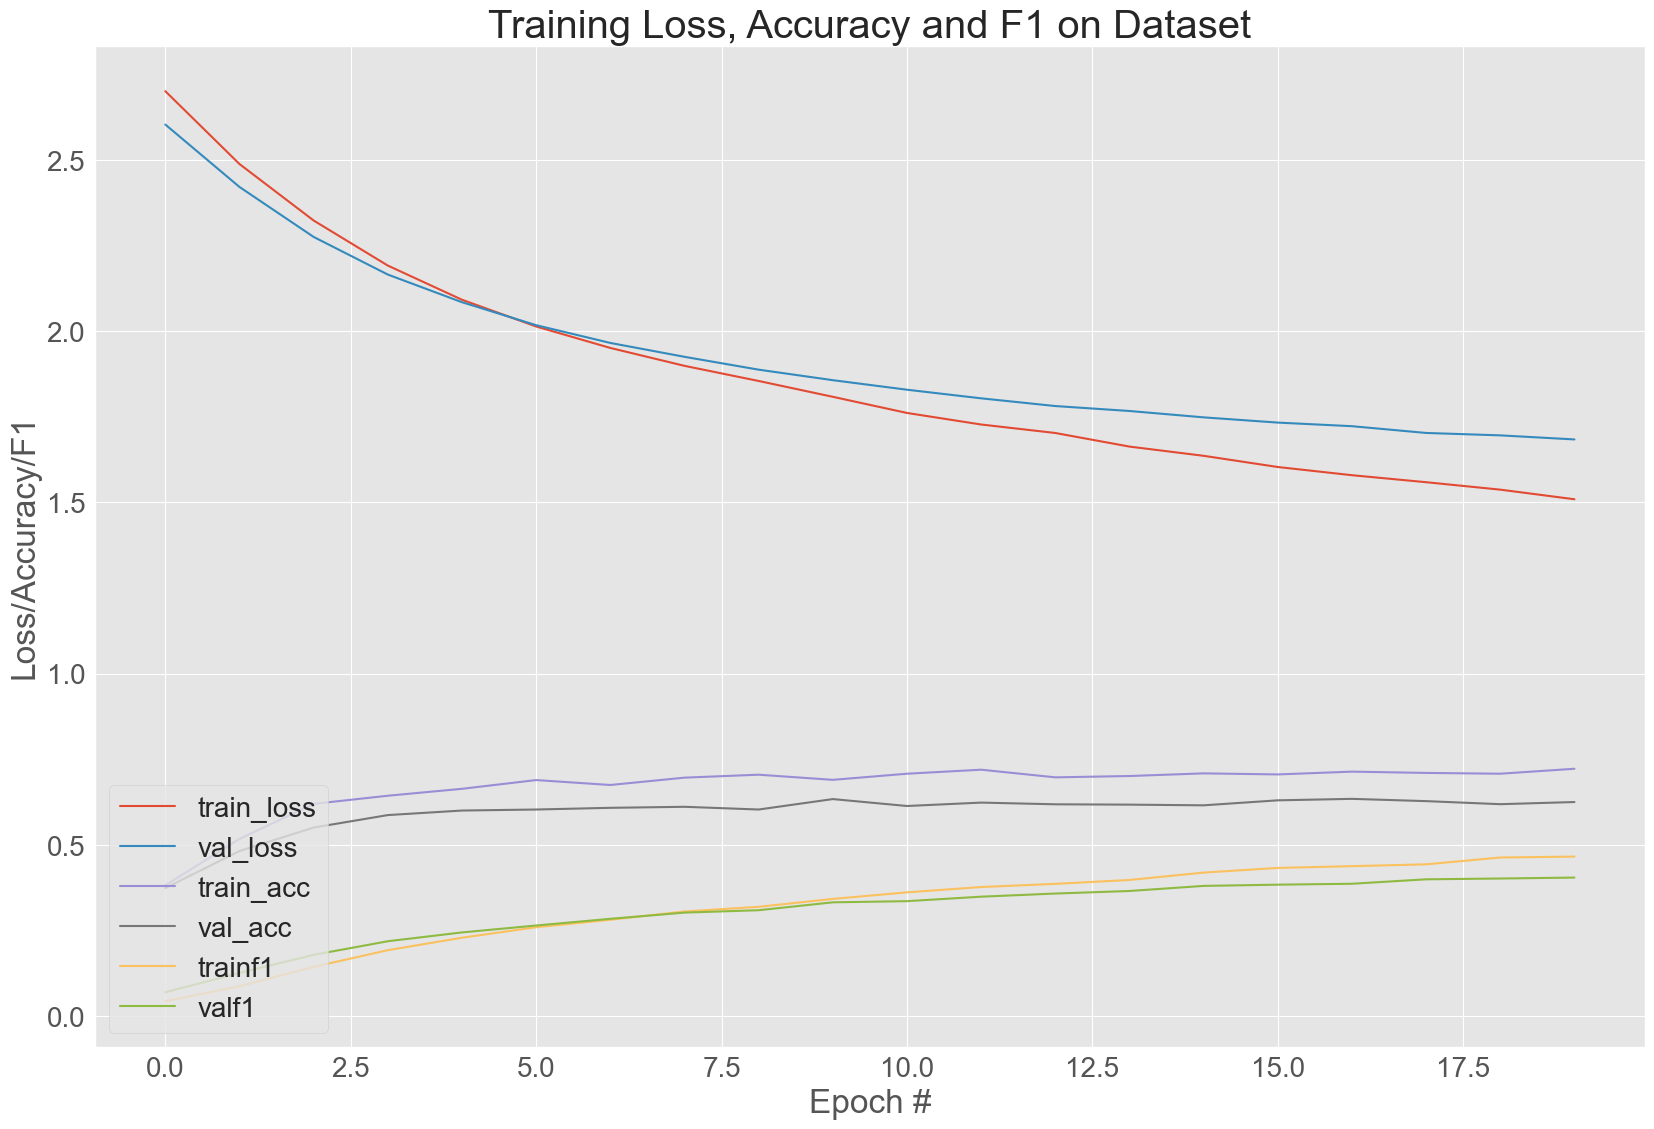

In [35]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.rcParams['font.size'] = 20
plt.figure(figsize=(20, 13))
plt.plot(metrics["train_loss"], label="train_loss")
plt.plot(metrics["val_loss"], label="val_loss")
plt.plot(metrics["train_acc"], label="train_acc")
plt.plot(metrics["val_acc"], label="val_acc")
plt.plot(metrics["trainf1"], label="trainf1")
plt.plot(metrics["valf1"], label="valf1")
plt.title("Training Loss, Accuracy and F1 on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(loc="lower left")

In [36]:
torch.cuda.empty_cache()